# Optical flow for ego-motion and structure estimation
In this notebook, we will study how we can determine ego-motion and structure with the help of optical flow from an image sequence. We assume a pinhole camera in this notebook. We first start with a theoretical derivation of the optical flow formulas (expressing the optical flow in terms of ego-motion and structure of the observed scene). Then we will discuss how structure and ego-motion can be obtained from these formulas. Finally, you can play with a Python script that determines important optical flow observables such as the divergence from an image sequence.

## Deriving the optical flow formula
Each point in an image $(x, y)$ has an associated optical flow $(u, v)$. Here we will derive an expression for the optical flow in terms of the movement of the camera, translational velocities $(U, V, W)$ and rotation rates $(A,B,C)$, and the coordinate of the projected point in the real world, $(X, Y, Z)$. This derivation is based on [1], from which we adopt the notation.

We also use the coordinate system as introduced in [1], which is shown in Figure 1. In the system, O represents the center of the camera, $X$ is positive toward the left, $Y$ positive up, and $Z$ is positive in the direction of the camera’s principal axis.

<CENTER>
<IMG SRC="coordinate_system.png" ALT="Coordinate system used in the optical flow derivation." WIDTH="500"></IMG>
<small>Figure 1: Coordinate system from [1].</small>
</CENTER>

We start with the formulas for the image coordinate of a world point $P$ at $(X, Y, Z)$:

$x = \frac{X}{Z}$ and $y = \frac{Y}{Z}$,

where the reader should note that $x$ and $y$ are _normalized_ image coordinates. The optical flow then is:

$u = \frac{\partial}{\partial t} x = \dot{x}$

and

$v = \frac{\partial}{\partial t} y = \dot{y}$

Here, we first express $\dot{x}$ and $\dot{y}$ in the variables representing the camera movement and $P$'s coordinate:

$\dot{x} = \frac{\dot{X}}{Z} - \frac{X \dot{Z}}{Z^2}$      (Eq. 1),

and

$\dot{y} = \frac{\dot{Y}}{Z} - \frac{Y \dot{Z}}{Z^2}$      (Eq. 2),

which shows that we should find the expressions for $\dot{X}$, $\dot{Y}$ and $\dot{Z}$.

We will determine the time derivative of $x$, as the derivation of $\dot{y}$ is similar. Let us start with $\dot{X}$, which captures the change in coordinate $X$ as measured from the camera's origin over time. Obviously, if the camera has a positive velocity $U$, in its own reference frame the (static) point $P$ will move with the same velocity in the other direction. So:

$\dot{X} = -U + \ldots$

<CENTER>
<IMG SRC="rotation_beta.png" WIDTH="200" ALT="Effect of a rotation around the Y-axis on the X-position of a point P."></IMG>
<small>Figure 2: Rotation around Y -axis, with rotation rate B.</small>
</CENTER>

Furthermore, a rotation around the $Y$-axis ($B$) also has an effect on the change in coordinate $X$. Please look at Figure 2, depicting a point P that is rotated with a rotation rate $B$. First, we can express $X$ and $Z$ in terms of the angle $\beta$ and distance of P to the origin, $R$:

$X = R \mathrm{cos}(\beta)$, and $Z = R \mathrm{sin}(\beta)$.

Then we can determine $\dot{X}$ as:

$\dot{X} = \dot{R} \mathrm{cos}(\beta) - R \mathrm{sin}(\beta) \dot{\beta}$,

where $\dot{R}=0$ for a rotation, and $\dot{\beta} = B$:

$\dot{X} = - R \mathrm{sin}(\beta) B = -B Z$,

where the last equality uses the equality $Z = R \mathrm{sin}(\beta)$. So this brings us to:

$\dot{X} = -U -BZ + \ldots$

A similar reasoning (left as exercise for the student) leads to the addition of $+CY$. The derivations for $\dot{Y}$ are also similar, with as result:

$\dot{X} = -U -BZ + CY$,
$\dot{Y} = -V -CX + AZ$,
$\dot{Z} = -W -AY + BX$.

We can fill in these expressions into Eq. 1 and 2:

$u = \dot{x} = \frac{-U -BZ + CY}{Z} - \frac{X (-W -AY + BX)}{Z^2}$,

which we can write differently as:

$u = \dot{x} = -\frac{U}{Z} - B + Cy + x \frac{W}{Z} + A x y - B x^2$,

where we have used $x = \frac{X}{Z}$ and $y = \frac{Y}{Z}$.

In [1], the optical flow formulas are finally written as follows:

__(Eq. 1)__ $u = (-\frac{U}{Z} - B + Cy) - x (-\frac{W}{Z} - A y + B x)$,

__(Eq. 2)__ $v = (-\frac{V}{Z} -Cx + A) -y (-\frac{W}{Z} - A y + B x)$.

Please note that $U,V,W,A,B,C$ are variables representing the observer's motion, and are hence the same for each observed point, but that $X,Y,Z$ (and thus $x,y$) are specific to each point.  

## Information available from optical flow
Optical flow contains information both about the observer's ego-motion and about the 3D-structure of the environment. Here, we will look at how such information is captured by the optical flow. 

The first thing to notice about the optical flow equations is that the flow has a separate translational and rotational component:

$u = -\frac{U}{Z} + x \frac{W}{Z} - A xy + B x^2 - B + Cy = u_T + u_R$,

$v = -\frac{V}{Z} + y\frac{W}{Z} -Cx + A  + A y^2 - B xy = v_T + v_R$.

Let us for now assume that we know the rotations, for instance by measuring the rotation rates with a gyro, and that we can cancel the rotational component of the optical flow. Then, we are left only with the translational component, which can provide us with interesting information. 

For instance, let's see what the physical meaning of the Focus of Expansion (FoE) is, the point in which the optical flow is zero:

$u_T = 0 = -\frac{U}{Z}  + x_{\mathrm{FoE}} \frac{W}{Z}$

$x_{\mathrm{FoE}} = \frac{U}{W}$

Similarly:
$v_T = 0 = -\frac{V}{Z} + y_{\mathrm{FoE}} \frac{W}{Z}$

$y_{\mathrm{FoE}} = \frac{V}{W}$

, so that:
$\frac{x_{\mathrm{FoE}}}{y_{\mathrm{FoE}}} = \frac{U}{V}$

indicates the direction in which the camera is travelling. So, if a robot can find the point where the optical flow is zero, it can find out in what direction it is moving. Also, we can show that all the flow will move away from this point. We first re-express $u_T$, $v_T$ as follows:
$u_T = (-U  + x W) / Z = (-\frac{U}{W} + x) \frac{W}{Z} = (x - x_{\mathrm{FoE}}) \frac{W}{Z}$
$v_T = (-\frac{V}{W} + y) \frac{W}{Z} = (y - y_{\mathrm{FoE}}) \frac{W}{Z}$
, which means that:
$u_T / v_T = (x - x_{\mathrm{FoE}}) / (y - y_{\mathrm{FoE}})$,
so that the optical flow always points straight away from the FoE. 

<CENTER>
<IMG SRC="focus_of_expansion.png" WIDTH="300" ALT="Translational flow is 0 in the focus of expansion (FoE) and all flow points away from the FoE when moving toward that point."></IMG>
<small>Figure 3: Translational flow is 0 in the focus of expansion (FoE) and all flow points away from the FoE when moving toward that point.</small>
</CENTER>

The equations above also show how to determine the relative velocity in the direction of the camera's principal axis:
$\frac{W}{Z} = \frac{u_T}{(x - x_{\mathrm{FoE}})} = \frac{v_T}{(y - y_{\mathrm{FoE}})}$,
, which is inversely related to the 'time-to-contact' $\frac{Z}{W}$ and the divergence $2\frac{W}{Z}$ (under a flat plane assumption). Please remark that $Z$ and hence $\frac{W}{Z}$ can be different per point. The motion orthogonal to the camera's principal axis is captured by $\frac{U}{Z}$ (in the $X$-direction) or $\frac{V}{Z}$ (in the $Y$-direction).

## Extracting information from the optical flow field
We are now going to extract information such as the relative velocity from an image sequence. The image sequence has been generated artificially, so that the observer moves straight towards a flat surface. Moreover, the observer is only translating, not rotating. 

<CENTER>
<table>
    <tr>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_1.jpg" WIDTH="100"></IMG> </th>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_30.jpg" WIDTH="100"></IMG> </th>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_60.jpg" WIDTH="100"></IMG> </th>
        <th> <IMG SRC="./image_sequence_pure_ver1/image_99.jpg" WIDTH="100"></IMG> </th>
    </tr>
</table> 
<small>Figure 4: Images from the image sequence (images 1, 30, 60, 99). The observer moves towards the surface in 100 frames.</small>
</CENTER>

Of course, in order to do anything, we first need to obtain a set of _optical flow vectors_, i.e., image coordinates $(x_i, y_i)$ with corresponding optical flow $(u_i, v_i)$.

<font color='red'><B>Exercise 1.</B></font>
Below, we import the Python script `extract_information_flow_field.py` <A HREF="https://github.com/guidoAI/optic_flow_notebook/blob/master/extract_information_flow_field.py" TARGET="_blank">(link to file)</A>, and first determine the flow on two images from the sequence. Please change the image numbers in the script (in between 1 and 99, as they correspond to the numbers in the image sequence illustrated in Fig. 4) in order to answer two questions:
1. Can you set the numbers in such a way that you see many "wrong" optical flow vectors? What settings lead to many faulty vectors?
2. What happens when the first number is higher than the second one? Where is the FoE in this case? 

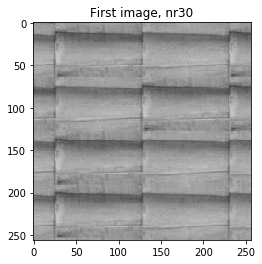

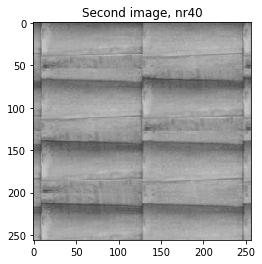

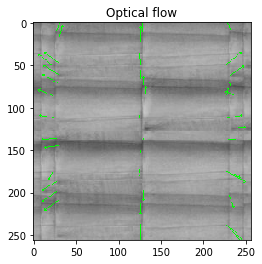

In [6]:
%matplotlib inline
import extract_information_flow_field as OF

# Change the image numbers below to answer the questions:
img_nr_1 = 30;
img_nr_2 = 40;
points_old, points_new, flow_vectors = OF.show_flow(img_nr_1, img_nr_2);

# Linear optical flow field estimation
In [2], a drone used optical flow to move down a stairs and then detect when it was flying over flat ground again, so that it would land. The article [2] uses the theory from [1] to estimate all relative velocities, and even the slope of the surface. It does so by assuming that there is a flat surface that fills the view, possibly under an angle with the camera (not orthogonal). This assumption results in an optical flow field that is quadratic with respect to the image coordinates. The reason for this is that $Z$ in the formulas for optical flow now becomes dependent on $x$. 

If one assumes that the surface is flat and _orthogonal_ to the camera, then $Z$ is the same for each coordinate in the image. Then, when looking only at the translational flow, the optical flow formulas (Eq. 1 and 2) lead to a linear flow field over the entire image:

__(Eq. 3)__ $u_T = -\frac{U}{Z} + x \frac{W}{Z}$

__(Eq. 4)__ $v_T = -\frac{V}{Z} + y \frac{W}{Z}$

In order to find out $\frac{U}{Z}$ and $\frac{W}{Z}$ in Eq. 3, we just need to perform a linear fit on the horizontal flow field. Given a linear fit $u_T = a x + b$, $a = \frac{W}{Z}$ and $b = -\frac{U}{Z}$. The linear fit would be based on the set of optical flow vectors found in the image, as follows:

$\mathbf{u} = \mathbf{p_u}^T [\mathbf{x} \quad \mathbf{1}]$

, where $\mathbf{u}$ is a (column) vector containing all the horizontal flow values $u_i$, $\mathbf{x}$ contains the corresponding $x$-coordinates $x_i$, $\mathbf{1}$ is a column of ones, and $\mathbf{p_u}$ contains the parameters that are to be fit, corresponding to $a = \frac{W}{Z}$ and $b = -\frac{U}{Z}$. Performing a similar fit for the vertical flow gives an estimate of $-\frac{V}{Z}$ and an additional estimate of $\frac{W}{Z}$.

<font color='red'><B>Exercise 2.</B></font>
Have a look at the code below. In this code, we solve the linear system explained above with the help of the Moore-Penrose pseudo inverse (see on <A HREF="https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse" TARGET="_blank">Wikipedia</A>). This code is similar to the code that is in the function `estimate_linear_flow_field` in the file `extract_information_flow_field.py`.
1. Please add a print statement that prints the ventral flows $\frac{U}{Z}$ and $\frac{V}{Z}$, and also the relative vertical velocity $\frac{W}{Z}$.
2. How good are the linear fits? How can you best judge this?
3. Can you change the image numbers (in the range 1 - 99) so that you get a 'wrong' fit? What makes the fit go wrong?


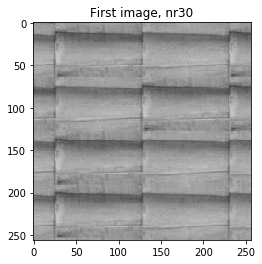

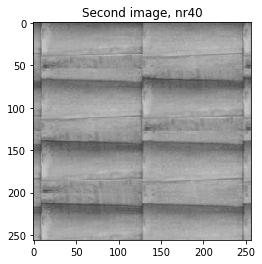

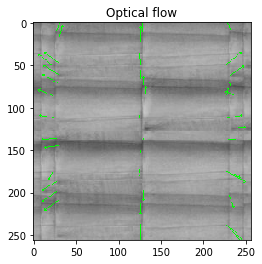

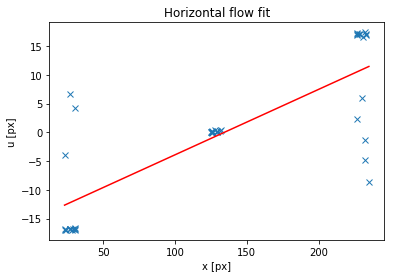

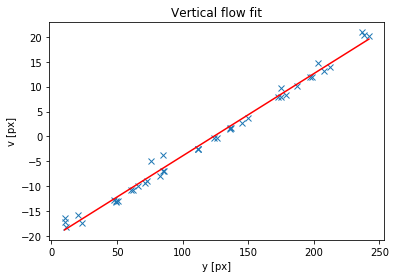

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Change the numbers of the images for answering the questions:
im_num1 = 30;
im_num2 = 40;
points_old, points_new, flow_vectors = OF.show_flow(im_num1, im_num2);

n_points = points_old.shape[0];

# make a matrix A with elements [x,1] 
A_hor = np.concatenate((points_old[:,0].reshape(n_points,1), np.ones([points_old.shape[0], 1])), axis=1);
# Moore-Penrose pseudo-inverse:
# https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse
pseudo_inverse_A_hor = np.linalg.pinv(A_hor);
# target = horizontal flow:
u_vector = flow_vectors[:,0];
# solve the linear system:
pu = np.dot(pseudo_inverse_A_hor, u_vector);
# calculate how good the fit is:
errs_u = np.abs(np.dot(A_hor, pu) - u_vector);

# Plot the fit:
plt.figure();
plt.plot(points_old[:,0], flow_vectors[:,0], 'x');
min_x = np.min(points_old[:,0]);
u_min_x = np.dot(np.asarray([min_x, 1]).reshape(1,2), pu);
max_x = np.max(points_old[:,0]);
u_max_x = np.dot(np.asarray([max_x, 1]).reshape(1,2), pu);
plt.plot([min_x, max_x], [u_min_x, u_max_x], 'r');
plt.xlabel('x [px]');
plt.ylabel('u [px]');
plt.title('Horizontal flow fit')

# make a matrix A with elements [y,1]
A_ver = np.concatenate((points_old[:,1].reshape(n_points,1), np.ones([points_old.shape[0], 1])), axis=1);
# Moore-Penrose pseudo-inverse:
# https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse
pseudo_inverse_A_ver = np.linalg.pinv(A_ver);
# target = vertical flow:
v_vector = flow_vectors[:,1];
pv = np.dot(pseudo_inverse_A_ver, v_vector);
errs_v = np.abs(np.dot(A_ver, pv) - v_vector);
err = (np.mean(errs_u) + np.mean(errs_v)) / 2.0;

# Plot the fit:
plt.figure();
plt.plot(points_old[:,1], flow_vectors[:,1], 'x');
min_y = np.min(points_old[:,1]);
v_min_y = np.dot(np.asarray([min_y, 1]).reshape(1,2), pv);
max_y = np.max(points_old[:,1]);
v_max_y = np.dot(np.asarray([max_y, 1]).reshape(1,2), pv);
plt.plot([min_y, max_y], [v_min_y, v_max_y], 'r');
plt.xlabel('y [px]');
plt.ylabel('v [px]');
plt.title('Vertical flow fit');

## Robust fitting
A 'normal' linear least squares fit is quite much influenced by outliers - because of the square error function. For this reason, in many vision applications, use is made of the random sample consensus algorithm, i.e., RANSAC (<A HREF="https://en.wikipedia.org/wiki/Random_sample_consensus" TARGET="_blank">Wikipedia</A>). The central idea behind RANSAC is to take as small a sample as possible from the data points for the fitting, and then determining the error on the total data set, while using a threshold for the error. Both the small sample size for the fitting and the threshold have as aim to reduce the influence of outliers. Namely, if one performs a certain number of samples and corresponding fits (called 'iterations' in the algorithm), there is a good chance that one of these samples only contains inliers. The threshold serves to reduce the influence of outliers on the goodness of the fit.

<font color='red'><B>Exercise 3.</B></font>
Look at the RANSAC code below. This algorithm is also available in the function `estimate_linear_flow_field` by setting `RANSAC=True`.

1. What are the differences of the linear fit with the algorithm explained in the previous section? What are the consequences of these differences?
2. The initial settings of this notebook do not result in a good fit. Please change the RANSAC parameters to achieve a better fit. What was the problem?

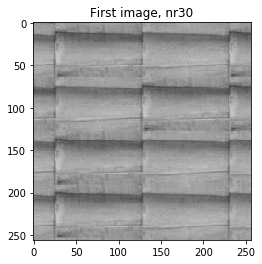

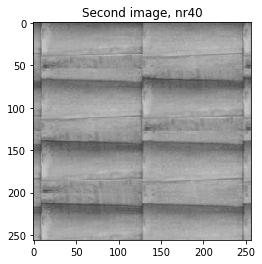

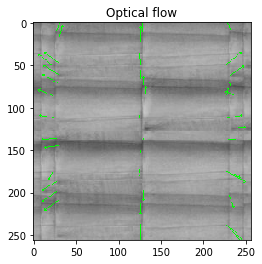

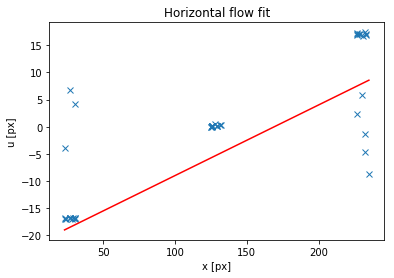

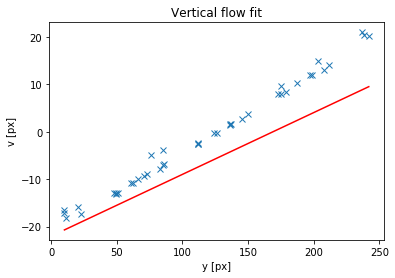

In [3]:
points_old, points_new, flow_vectors = OF.show_flow(30,40);

n_points = points_old.shape[0];

#RANSAC parameters - change to do the exercise:
n_iterations=2;
error_threshold=100.0;
sample_size = 30; # 3 is the minimum for this fit. You can set it higher, though.

 # This is a RANSAC method to better deal with outliers
# matrices and vectors for the big system:
A = np.concatenate((points_old, np.ones([points_old.shape[0], 1])), axis=1);
u_vector = flow_vectors[:,0];
v_vector = flow_vectors[:,1];

# solve many small systems, calculating the errors:
errors = np.zeros([n_iterations, 2]);
pu = np.zeros([n_iterations, 3])
pv = np.zeros([n_iterations, 3])
for it in range(n_iterations):
    inds = np.random.choice(range(n_points), size=sample_size, replace=False);
    AA = np.concatenate((points_old[inds,:], np.ones([sample_size, 1])), axis=1);
    pseudo_inverse_AA = np.linalg.pinv(AA);
    # horizontal flow:
    u_vector_small = flow_vectors[inds, 0];
    # pu[it, :] = np.linalg.solve(AA, UU);
    pu[it,:] = np.dot(pseudo_inverse_AA, u_vector_small);
    errs = np.abs(np.dot(A, pu[it,:]) - u_vector);
    errs[errs > error_threshold] = error_threshold;
    errors[it, 0] = np.mean(errs);
    # vertical flow:
    v_vector_small = flow_vectors[inds, 0];
    # pv[it, :] = np.linalg.solve(AA, VV);
    pv[it, :] = np.dot(pseudo_inverse_AA, v_vector_small);
    errs = np.abs(np.dot(A, pv[it,:]) - v_vector);
    errs[errs > error_threshold] = error_threshold;
    errors[it, 1] = np.mean(errs);

# take the minimal error
errors = np.mean(errors, axis=1);
ind = np.argmin(errors);
err = errors[ind];
pu = pu[ind, :];
pv = pv[ind, :];

# Plot the fit:
pu = np.asarray([pu[0], pu[2]]).reshape(2,1);
plt.figure();
plt.plot(points_old[:,0], flow_vectors[:,0], 'x');
min_x = np.min(points_old[:,0]);
u_min_x = np.dot(np.asarray([min_x, 1]).reshape(1,2), pu);
u_min_x = u_min_x[0][0];
max_x = np.max(points_old[:,0]);
u_max_x = np.dot(np.asarray([max_x, 1]).reshape(1,2), pu);
u_max_x = u_max_x[0][0];
plt.plot([min_x, max_x], [u_min_x, u_max_x], 'r');
plt.xlabel('x [px]');
plt.ylabel('u [px]');
plt.title('Horizontal flow fit')

# Plot the fit:
pv = np.asarray([pv[0], pv[2]]).reshape(2,1);
plt.figure();
plt.plot(points_old[:,1], flow_vectors[:,1], 'x');
min_y = np.min(points_old[:,1]);
v_min_y = np.dot(np.asarray([min_y, 1]).reshape(1,2), pv);
v_min_y = v_min_y[0][0];
max_y = np.max(points_old[:,1]);
v_max_y = np.dot(np.asarray([max_y, 1]).reshape(1,2), pv);
v_max_y = v_max_y[0][0];
plt.plot([min_y, max_y], [v_min_y, v_max_y], 'r');
plt.xlabel('y [px]');
plt.ylabel('v [px]');
plt.title('Vertical flow fit');

## Applying the fits to an entire 'landing sequence'
Now we are ready to apply the (RANSAC) linear fit to an entire landing sequence. In the Python file this is done by the function `extract_flow_information`. We reproduce the code below, so that you can change it.

<font color='red'><B>Exercise 4.</B></font> 

1. When running the code below with the initial values, most of the lines in the figures are completely flat (0.0). Search for 'EXERCISE' in the Python code below, and use the parameters from the linear fits to determine relative horizontal and vertical motion, the focus of expansion (FoE), the divergence, and the time-to-contact. *Advice*: look into the function ```estimate_linear_flow_field``` and realize that for both horizontal and vertical flow a 3-parameter fit is performed: $u = ax + by + c$. For horizontal flow, the vertical component ($by$) can be ignored, and for the vertical flow the horizontal component ($ax$).
2. How accurate are the values over time, knowing that the image sequence was generated by simulating a constant approach speed? What factors determine this accuracy do you think?

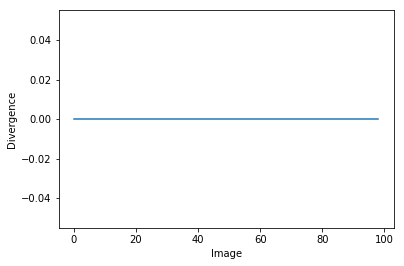

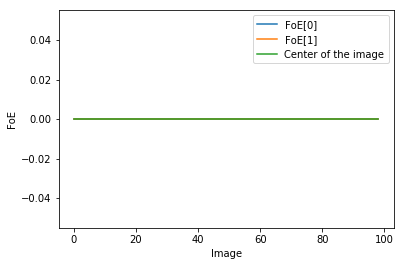

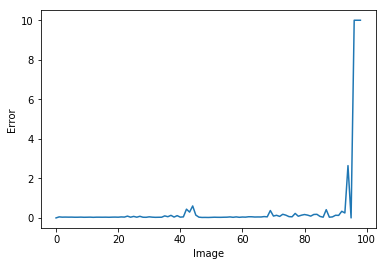

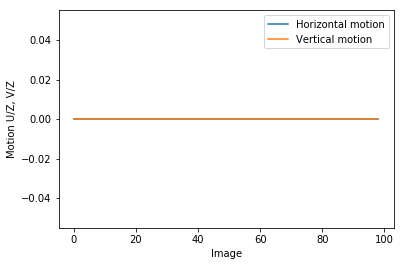

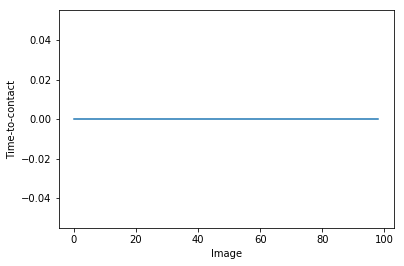

In [4]:
#OF.extract_flow_information(flow_graphics=False, verbose=False);

import os
import re
import time
import sys
import cv2

# parameters - keep them like this:
image_dir_name = './image_sequence_pure_ver1/';
image_type = 'jpg'; 
verbose=False;
graphics =True;
flow_graphics = False;
    
# get the image names from the directory:
image_names = [];
for file in os.listdir(image_dir_name):
    if file.endswith(image_type):
        image_names.append(image_dir_name + file);
if sys.version_info[0] < 3:
    # Python 2:
    image_names.sort(cmp=compare_file_names);
else:
    # Python 3:
    image_names.sort(key=OF.get_number_file_name);

# iterate over the images:
n_images = len(image_names);
FoE_over_time = np.zeros([n_images, 2]);
horizontal_motion_over_time = np.zeros([n_images, 1]);
vertical_motion_over_time = np.zeros([n_images, 1]);
divergence_over_time = np.zeros([n_images, 1]);
errors_over_time = np.zeros([n_images, 1]);
elapsed_times = np.zeros([n_images,1]);
ttc_over_time = np.zeros([n_images,1]);
FoE = np.asarray([0.0]*2);
time_to_contact = 0.0;
for im in np.arange(0, n_images, 1):

    bgr = cv2.imread(image_names[im]);

    if(im > 0):

        t_before = time.time()
        # determine optical flow:
        points_old, points_new, flow_vectors = OF.determine_optical_flow(prev_bgr, bgr, graphics=flow_graphics);
        # do stuff
        elapsed = time.time() - t_before;
        if(verbose):
            print('Elapsed time = {}'.format(elapsed));
        elapsed_times[im] = elapsed;

        # convert the pixels to a frame where the coordinate in the center is (0,0)
        points_old -= 128.0;

        # extract the parameters of the flow field:
        pu, pv, err = OF.estimate_linear_flow_field(points_old, flow_vectors, RANSAC=True);
        
        # ***********************************
        # EXERCISE:
        # change the following lines of code!
        # ***********************************
        horizontal_motion = 0.0;
        vertical_motion = 0.0;
        divergence = 0.0;
        FoE[0] = 0.0; 
        FoE[1] = 0.0;    
        time_to_contact = 0.0;

        # book keeping:
        horizontal_motion_over_time[im] = horizontal_motion;
        vertical_motion_over_time[im] = vertical_motion;
        FoE_over_time[im, 0] = FoE[0];
        FoE_over_time[im, 1] = FoE[1];
        divergence_over_time[im] = divergence;
        errors_over_time[im] = err;
        ttc_over_time[im] = time_to_contact;

        if(verbose):
            # print the FoE and divergence:
            print('error = {}, FoE = {}, {}, and divergence = {}'.format(err, FoE[0], FoE[1], divergence));

    # the current image becomes the previous image:
    prev_bgr = bgr;
    
if(verbose):
    print('*** average elapsed time = {} ***'.format(np.mean(elapsed_times[1:,0])));

if(graphics):

    # ********************************************************************
    # TODO:
    # What is the unit of the divergence?
    # Can you also draw the time-to-contact over time? In what unit is it?
    # ********************************************************************

    plt.figure();
    plt.plot(range(n_images), divergence_over_time, label='Divergence');
    plt.xlabel('Image')
    plt.ylabel('Divergence')

    plt.figure();
    plt.plot(range(n_images), FoE_over_time[:,0], label='FoE[0]');
    plt.plot(range(n_images), FoE_over_time[:,1], label='FoE[1]');
    plt.plot(range(n_images), np.asarray([0.0]*n_images), label='Center of the image')
    plt.legend();
    plt.xlabel('Image')
    plt.ylabel('FoE')

    plt.figure();
    plt.plot(range(n_images), errors_over_time, label='Error');
    plt.xlabel('Image')
    plt.ylabel('Error')

    plt.figure();
    plt.plot(range(n_images), horizontal_motion_over_time, label='Horizontal motion');
    plt.plot(range(n_images), vertical_motion_over_time, label='Vertical motion');
    plt.legend();
    plt.xlabel('Image')
    plt.ylabel('Motion U/Z, V/Z')       

    plt.figure();
    plt.plot(range(n_images), ttc_over_time, label='Time-to-contact');
    plt.xlabel('Image')
    plt.ylabel('Time-to-contact')

## References
[1] H Christopher Longuet-Higgins and Kvetoslav Prazdny. The interpretation of a moving retinal image. Proceedings of the Royal Society of London B: Biological Sciences, 208(1173):385–397, 1980.

[2] G C H E de Croon, H W Ho, C De Wagter, E Van Kampen, B Remes, and QP Chu. Optic-flow based slope estimation for autonomous landing. International Journal of Micro Air Vehicles, 5(4):287–298, 2013.

## Answers

Exercise 1.

1. Setting a large difference in image number can lead to large errors in the optical flow. For example, using image numbers 30 and 90. The reason is that the images are then so different, that the Lucas Kanade method has a hard time matching local patterns in the images.

2. Setting, e.g., 40 and 30, as image numbers leads to a _contracting_ flow. The observer moves away from the scene (in a landing scenario up), and the flow points to the _focus of contraction_.

Exercise 2.

1. ```print('pu = {} (W/Z), {} (-U/Z)'.format(pu[0], pu[1])); print('pv = {} (W/Z), {} (-V/Z)'.format(pv[0], pv[1]));```
2. The fit for $u$ is worse than for $v$ when setting the images to 30, 40. This can be seen visually, but even better (more objectively) from the errors of the fit: ```print('Error u = {}, error v = {}'.format(np.mean(errs_u), np.mean(errs_v)));``` 
3. Setting the range for the image numbers too wide (30, 90 or even 30, 50) results in 'wrong' fits. The reason is that there are more and more faulty optical flow vectors. Outliers heavily influence the result. This can already be seen for $u$ for 30,40.

Exercise 3. 

1. Multiple linear fits are performed, with fewer samples, and the goodness of the fit is evaluated with a threshold to reduce the influence of outliers. However, the initial settings, 2 iterations, an error threshold of 100.0, and 30 samples almost results in worse fits. The reason is that only 2 fits are made with 30 samples, so that there is a large chance that there are still outliers that influence the fit. Moreover, the threshold is so high, that outliers will just be included.
2. Changing the settings to 50 iterations, an error threshold of 10.0 and 3 samples gives good fits, robust to outliers.

Exercise 4. 

1. The following code gives good results:
```        
        horizontal_motion = -pu[2];
        vertical_motion = -pv[2];
        divergence = (pu[0] + pv[1]) / 2.0;
        small_threshold = 1E-5;
        if(abs(pu[0]) > small_threshold):
            FoE[0] = pu[2] / pu[0]; 
        if(abs(pv[1]) > small_threshold):
            FoE[1] = pv[2] / pv[1];    
        if(abs(divergence) > small_threshold):
            time_to_contact = 1 / divergence;
```
2. To validate the accuracy, we should know the ground truth. Given our knowledge of the motion, the FoE should lie in the center (0,0), and the horizontal and vertical motion should be 0. The focus of expansion is hardest to estimate, but it is generally lower than 5 pixels for the 240$\times$240 images, which is acceptable. The time-to-contact is easily evaluated, as it should decrease linearly from 100 image frames to 0 image frames (with steps of 1). Plot an additional line in the time-to-contact graph with: ```plt.plot([0, 100], [100,0], '--k');```. Whether the divergence is well estimated is harder to evaluate visually due to the nonlinearity, but can be done by adding the following line in the plot:
```
    steps = np.arange(100, 5, -1);
    divergence = 1/steps;
    plt.plot(np.arange(0, 95), divergence, '--k');
```